In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
import pickle
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score 

%load_ext autoreload
%autoreload 2

file_path = "../data/carotenoid_training_data.csv"
df = pd.read_csv(file_path)
INPUT_VARS = df.columns[:-1]
INPUT_VARS = list(INPUT_VARS.values)
RESPONSE_VARS = [df.columns[-1]]

print(f"Input variables: {INPUT_VARS}" f"\nResponse variable: {RESPONSE_VARS}")
print(f"Shape of the dataframe: {df.shape}")


# Calculate bounds of proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float = 0.10):
    bounds = pd.DataFrame(columns=input_vars)
    X = df[input_vars]
    for col in input_vars:
        MAX = X[col].max()
        MIN = X[col].min()
        DELTA = MAX - MIN
        lb = MIN - epsilon * DELTA
        ub = MAX + epsilon * DELTA
        if lb < 0:
            lb = 0
        bounds.loc["min", col] = lb
        bounds.loc["max", col] = ub
    return bounds


# Create train/test sets
df.sort_values(by="prod", ascending=False, inplace=True)
test = df[:10].copy()
train = df[10:].copy()

X_train = train.drop("prod", axis=1)
y_train = train["prod"].values.ravel()

X_test = test.drop("prod", axis=1)
y_test = test["prod"].values.ravel()

bounds = get_bounds(train, INPUT_VARS)
display(bounds)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Input variables: ['ERG8', 'ERG10', 'ERG12', 'ERG13', 'ERG19', 'ERG20', 'IDI1', 'tHMG1']
Response variable: ['prod']
Shape of the dataframe: (168, 9)


,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1
min,0,0,0,0,0,0,0,0
max,21.70044,21.762191,25.856475,23.314336,21.509215,22.215345,5.881847,12.536361


In [38]:
try:
    with open("../models/xgb_carotenoid.pkl", "rb") as f:
        final_model = pickle.load(f)
        final_model.fit(X_train, y_train)
except FileNotFoundError:
    # Define the objective function for Optuna
    def objective(trial):
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-4, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-4, 1.0, log=True),
            "max_depth": trial.suggest_int("max_depth", 1, 10),
            "eta": trial.suggest_float("eta", 0.01, 1.0, log=True),
            "gamma": trial.suggest_float("gamma", 1e-4, 1.0, log=True),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "n_estimators": trial.suggest_int("n_estimators", 5, 300)
        }
        
        model = xgb.XGBRegressor(**params)
        scores = cross_val_score(model, X_train, y_train, cv=3, )
        return -scores.mean()

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100, show_progress_bar=True)
    best_params = study.best_params
    best_score = study.best_value    
    final_model = xgb.XGBRegressor(**best_params)
    final_model.fit(X_train, y_train)

In [37]:
def bootstrap(X, y, model: object, n: int = 100):
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
    return mae_values

mae_values = bootstrap(X_train, y_train, final_model)
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")
final_model.fit(X_train, y_train)

with open("../models/xgb_carotenoid.pkl", "wb") as f:
    final_model.fit(X_train, y_train)
    pickle.dump(final_model, f)

100%|██████████| 100/100 [00:03<00:00, 27.85it/s]


Bootstraped Mean(MAE) = 1.261262034024225


#### Explainable AI 

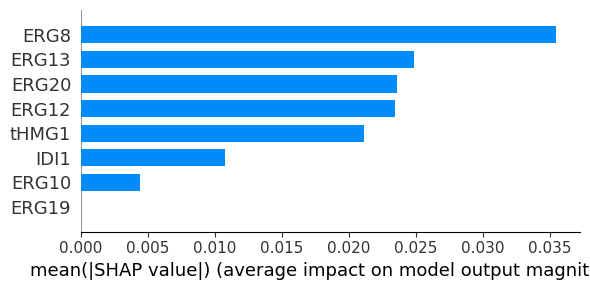

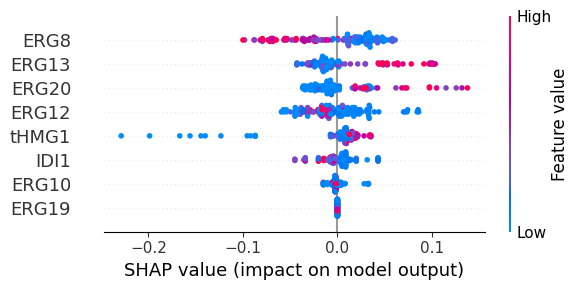

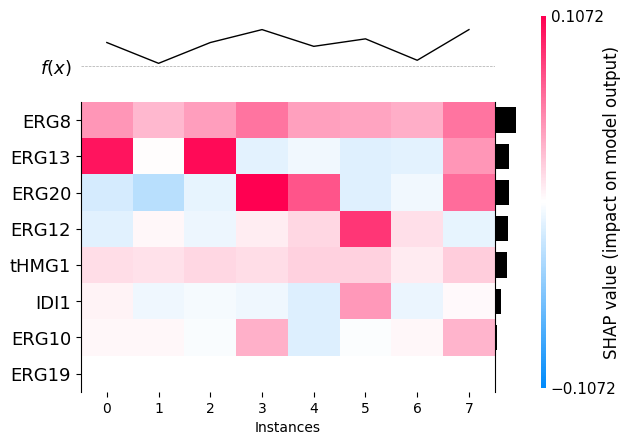

In [39]:
import shap
import matplotlib.pyplot as plt
from alibi.explainers import ALE, PartialDependence, plot_ale, plot_pd

def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])


explainer = shap.Explainer(final_model.predict, train[INPUT_VARS])
shap_values = explainer(train[INPUT_VARS])
shap.summary_plot(shap_values, train[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, train[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(0), plot_width=6)

In [ ]:
feature = "ERG8"
pdplot(train[INPUT_VARS], feature, final_model, ice=False)
shap_scatter(feature)

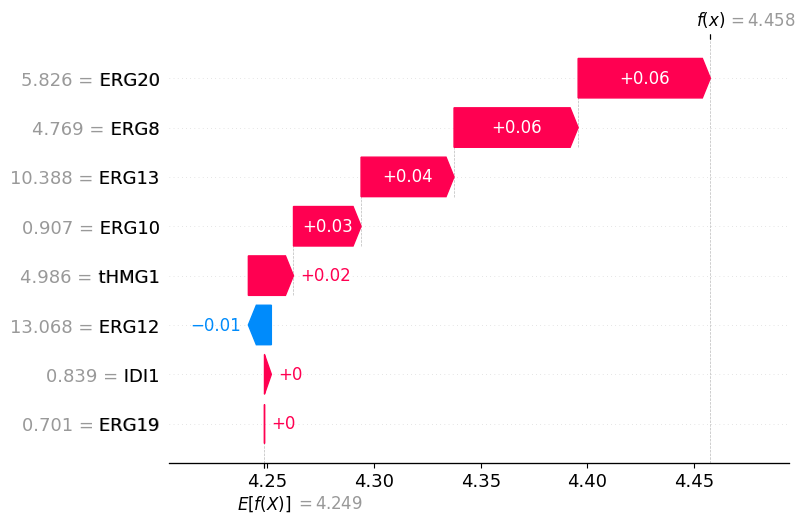

In [8]:
idx = 2
shap.plots.waterfall(shap_values[idx])

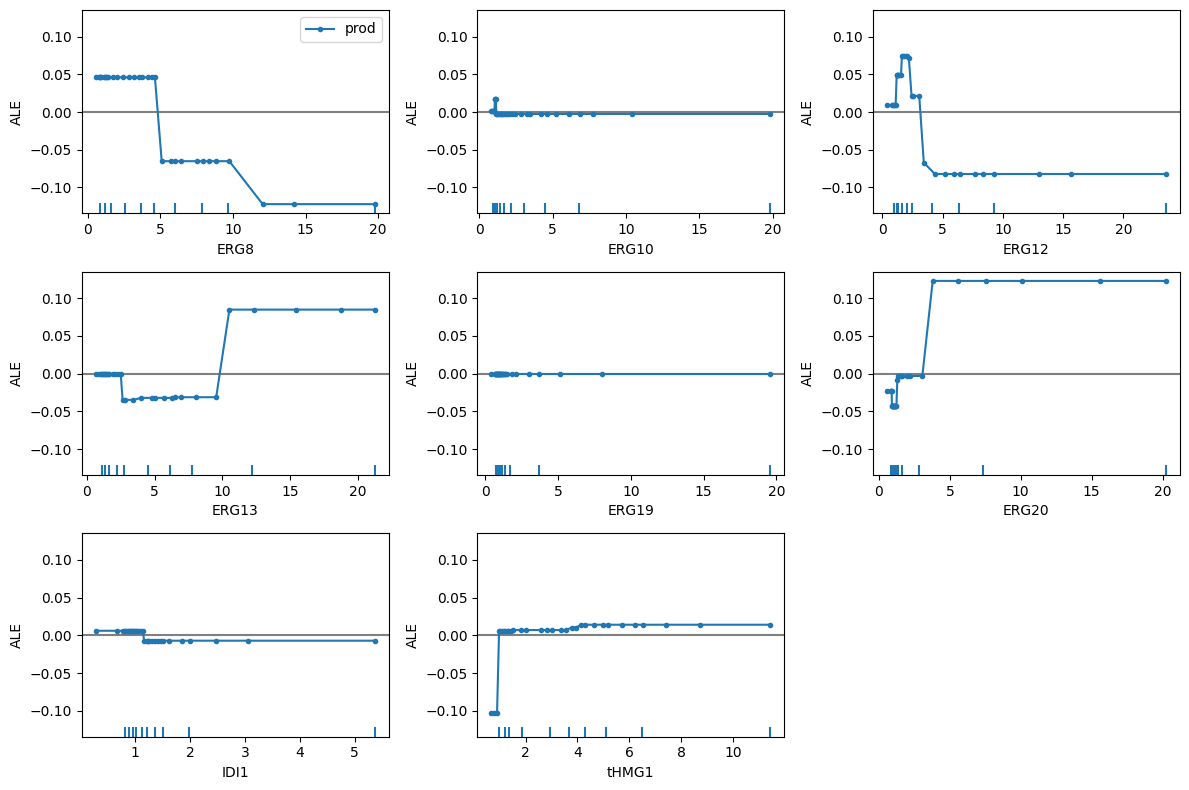

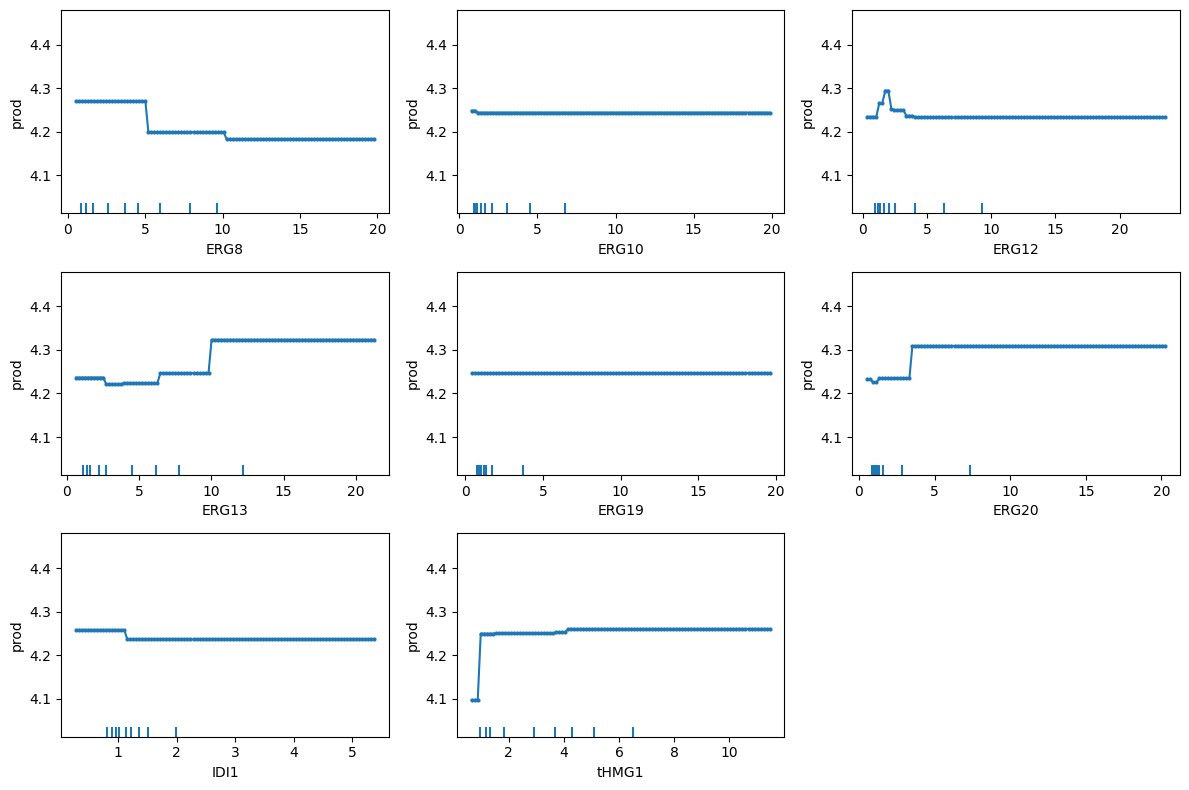

In [40]:
ale = ALE(final_model.predict, feature_names=INPUT_VARS, target_names=RESPONSE_VARS)
exp = ale.explain(train[INPUT_VARS].values)
plot_ale(exp, fig_kw={"figwidth": 12, "figheight": 8})
plt.show()

pdp = PartialDependence(predictor=final_model.predict, feature_names=INPUT_VARS, target_names=RESPONSE_VARS)
exp = pdp.explain(train[INPUT_VARS].values)
plot_pd(exp, fig_kw={"figwidth": 12, "figheight": 8})
plt.show()

# Synthetic data generation

# Sampling

In [63]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds["ERG8"].loc["min"] = 13
sampling_bounds["ERG8"].loc["max"] = bounds["ERG8"].loc["max"]

sampling_bounds["ERG10"].loc["min"] = 1.75
sampling_bounds["ERG10"].loc["max"] = bounds["ERG10"].loc["max"]

sampling_bounds["ERG12"].loc["min"] = bounds["ERG12"].loc["min"]
sampling_bounds["ERG12"].loc["max"] = 1.0

sampling_bounds["ERG13"].loc["min"] = bounds["ERG13"].loc["min"]
sampling_bounds["ERG13"].loc["max"] = 1.0

sampling_bounds["ERG19"].loc["min"] = bounds["ERG19"].loc["min"]
sampling_bounds["ERG19"].loc["max"] = 0.7

sampling_bounds["ERG20"].loc["min"] = 3.0
sampling_bounds["ERG20"].loc["max"] = bounds["ERG20"].loc["max"]

sampling_bounds["IDI1"].loc["min"] = bounds["IDI1"].loc["min"]
sampling_bounds["IDI1"].loc["max"] = 0.6

sampling_bounds["tHMG1"].loc["min"] = 1
sampling_bounds["tHMG1"].loc["max"] = bounds["tHMG1"].loc["max"]


# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(100)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(10)

,ERG8,ERG10,ERG12,ERG13,ERG19,ERG20,IDI1,tHMG1,pred
0,15.170889,2.444623,0.482976,0.401760,0.293134,16.322539,0.527386,10.278227,4.177505
57,13.185519,12.842896,0.332894,0.288186,0.468669,19.034617,0.410280,5.252517,4.177505
72,19.843186,18.472544,0.273196,0.615547,0.120470,16.071400,0.061317,8.557113,4.177505
70,19.720402,17.731727,0.814892,0.930684,0.637185,21.839315,0.378748,5.276113,4.177505
69,18.466731,4.717684,0.839056,0.422400,0.070153,14.501221,0.213046,6.237274,4.177505
63,19.662849,6.272248,0.495102,0.763351,0.282125,21.246399,0.156699,5.423766,4.177505
62,21.061994,12.210955,0.291038,0.158740,0.193916,20.706113,0.074164,3.732233,4.177505
61,21.301960,8.897664,0.745084,0.540707,0.419822,12.507424,0.168157,11.578467,4.177505
59,17.895544,8.976342,0.201816,0.480199,0.365642,21.793930,0.111981,8.040662,4.177505
58,16.998604,12.621875,0.329871,0.914012,0.695996,10.318790,0.502170,6.912741,4.177505


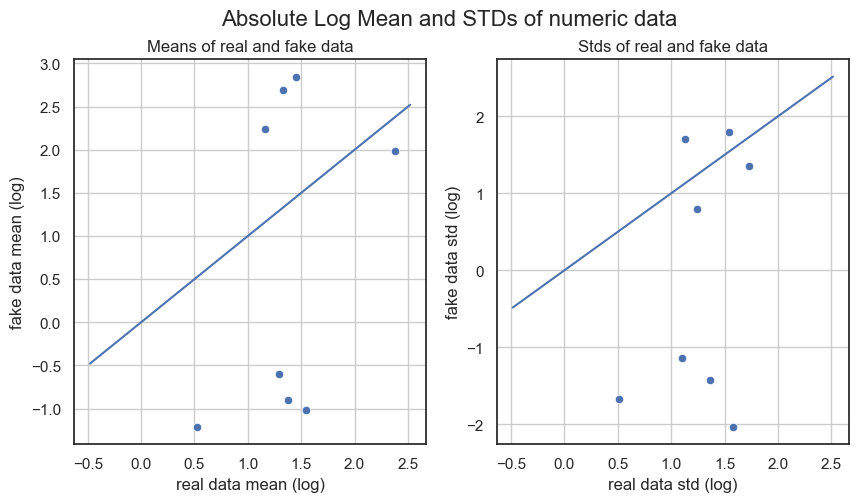

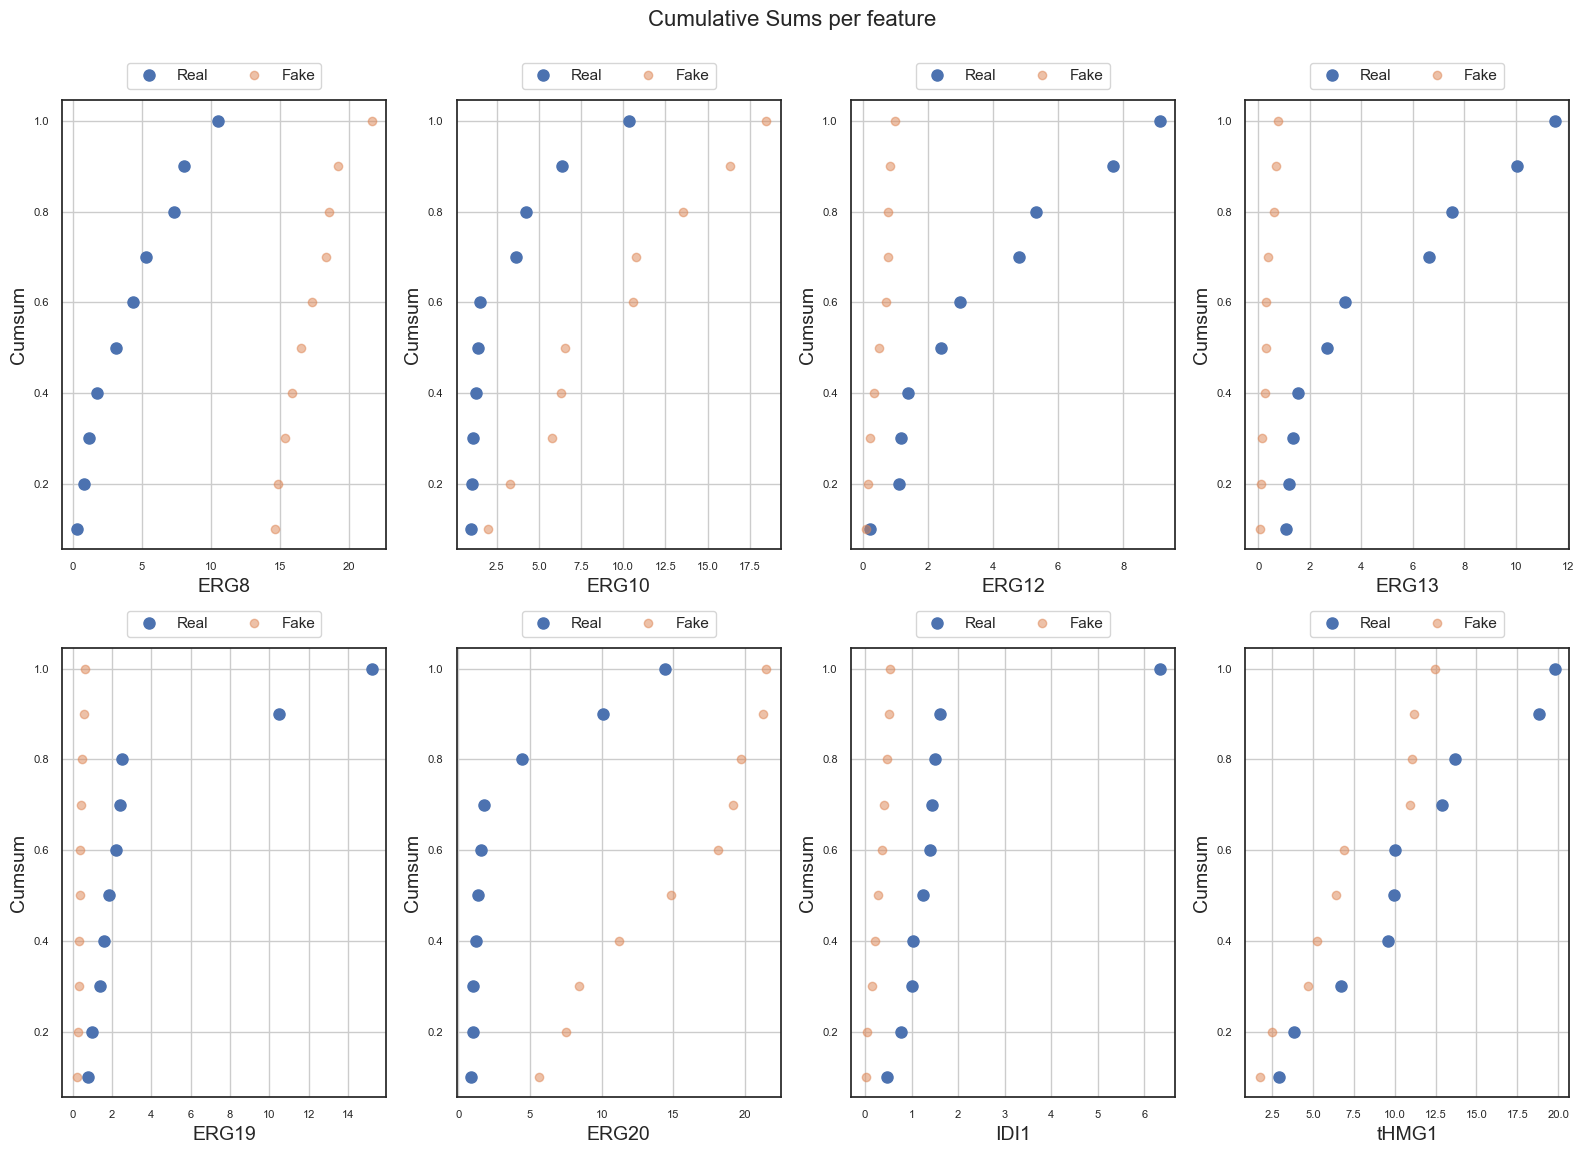

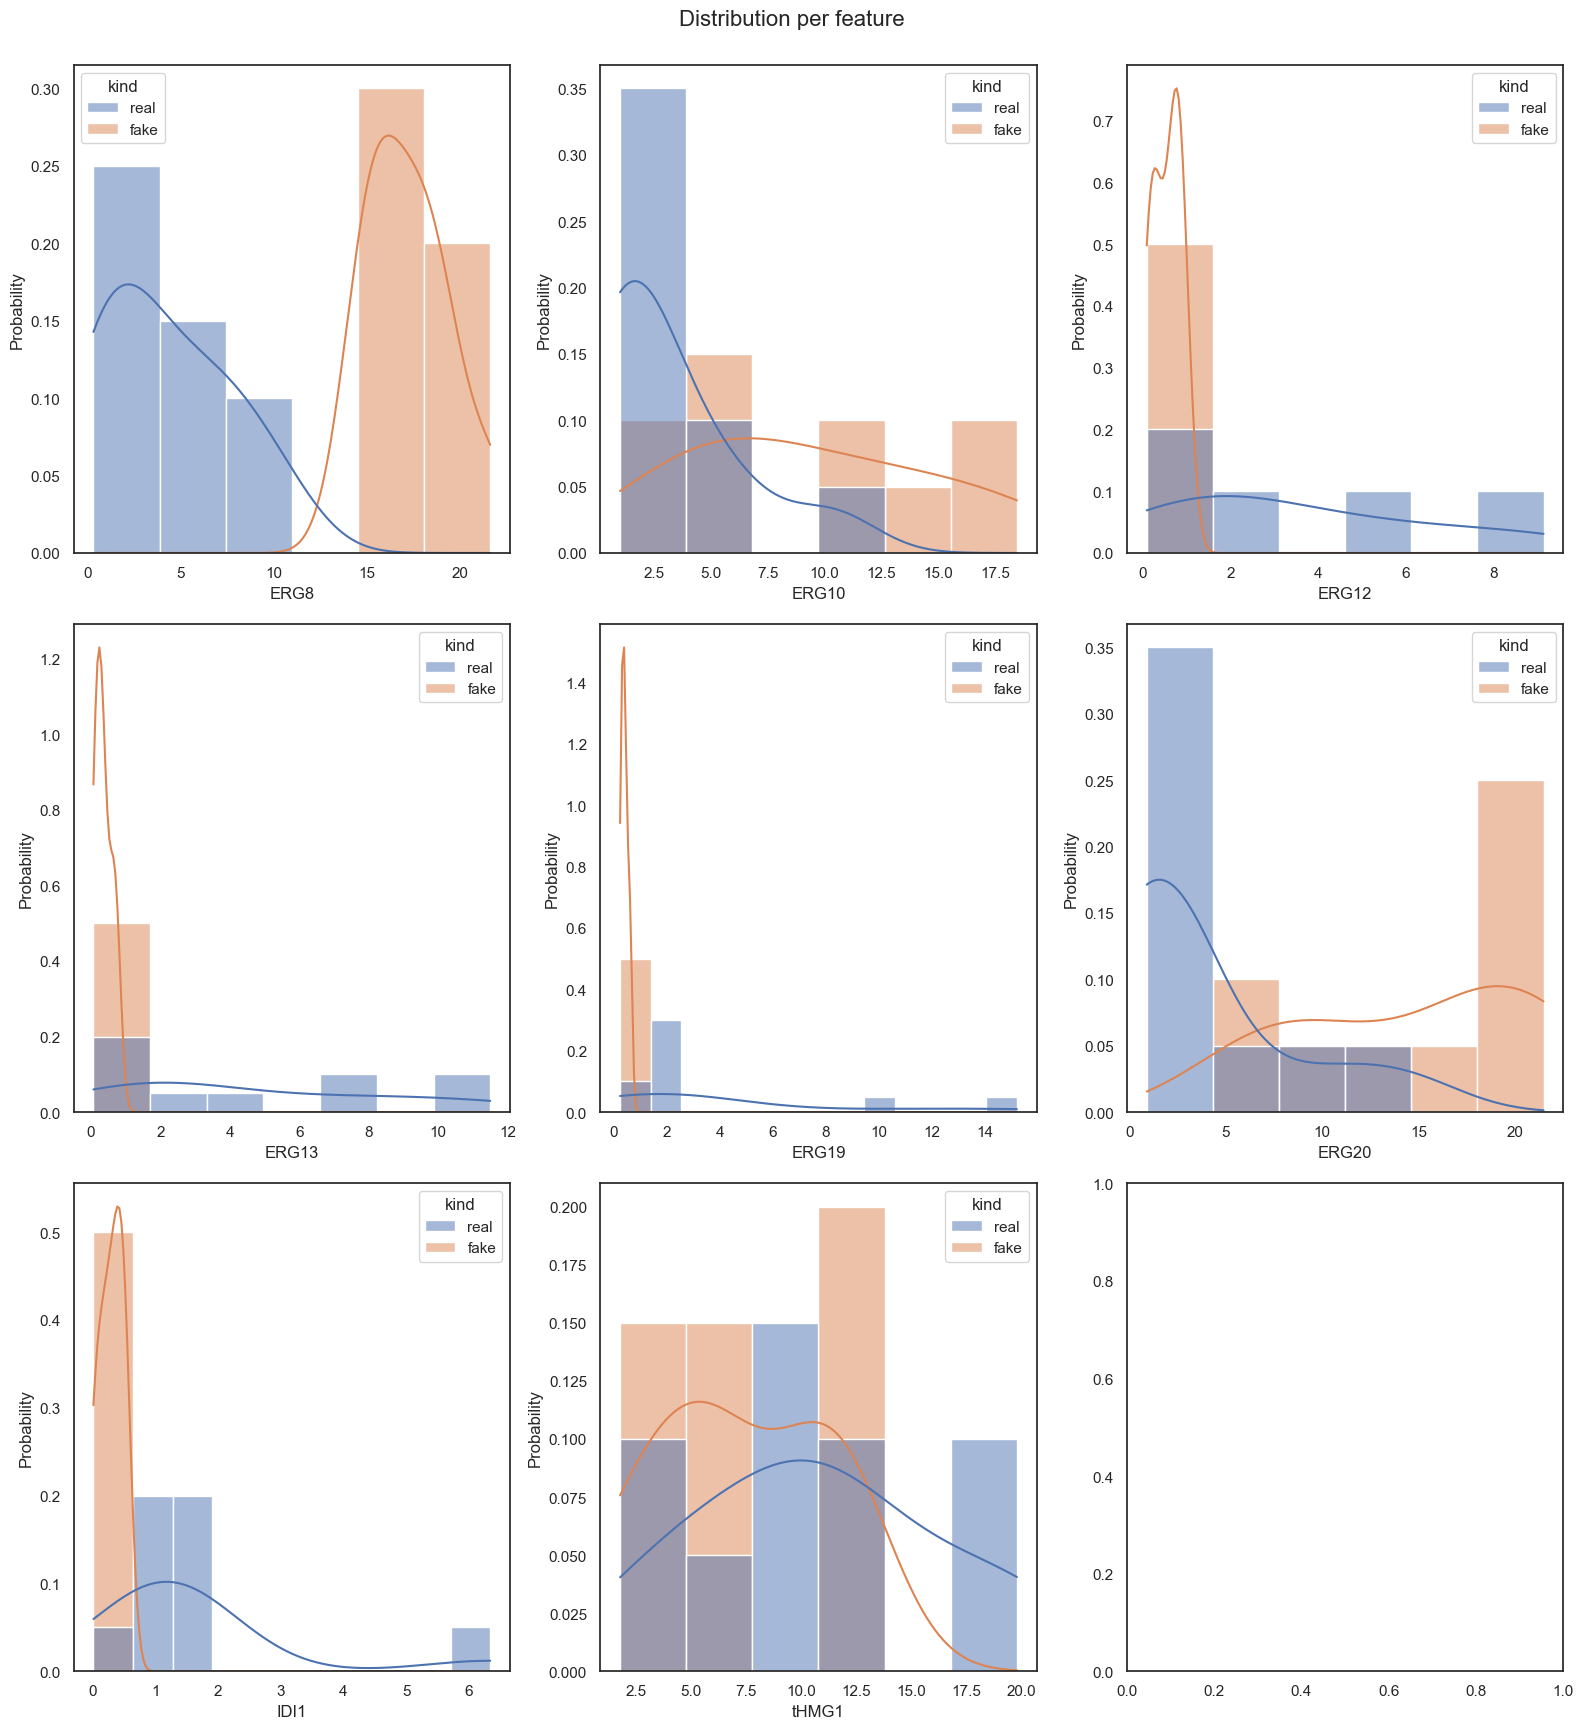

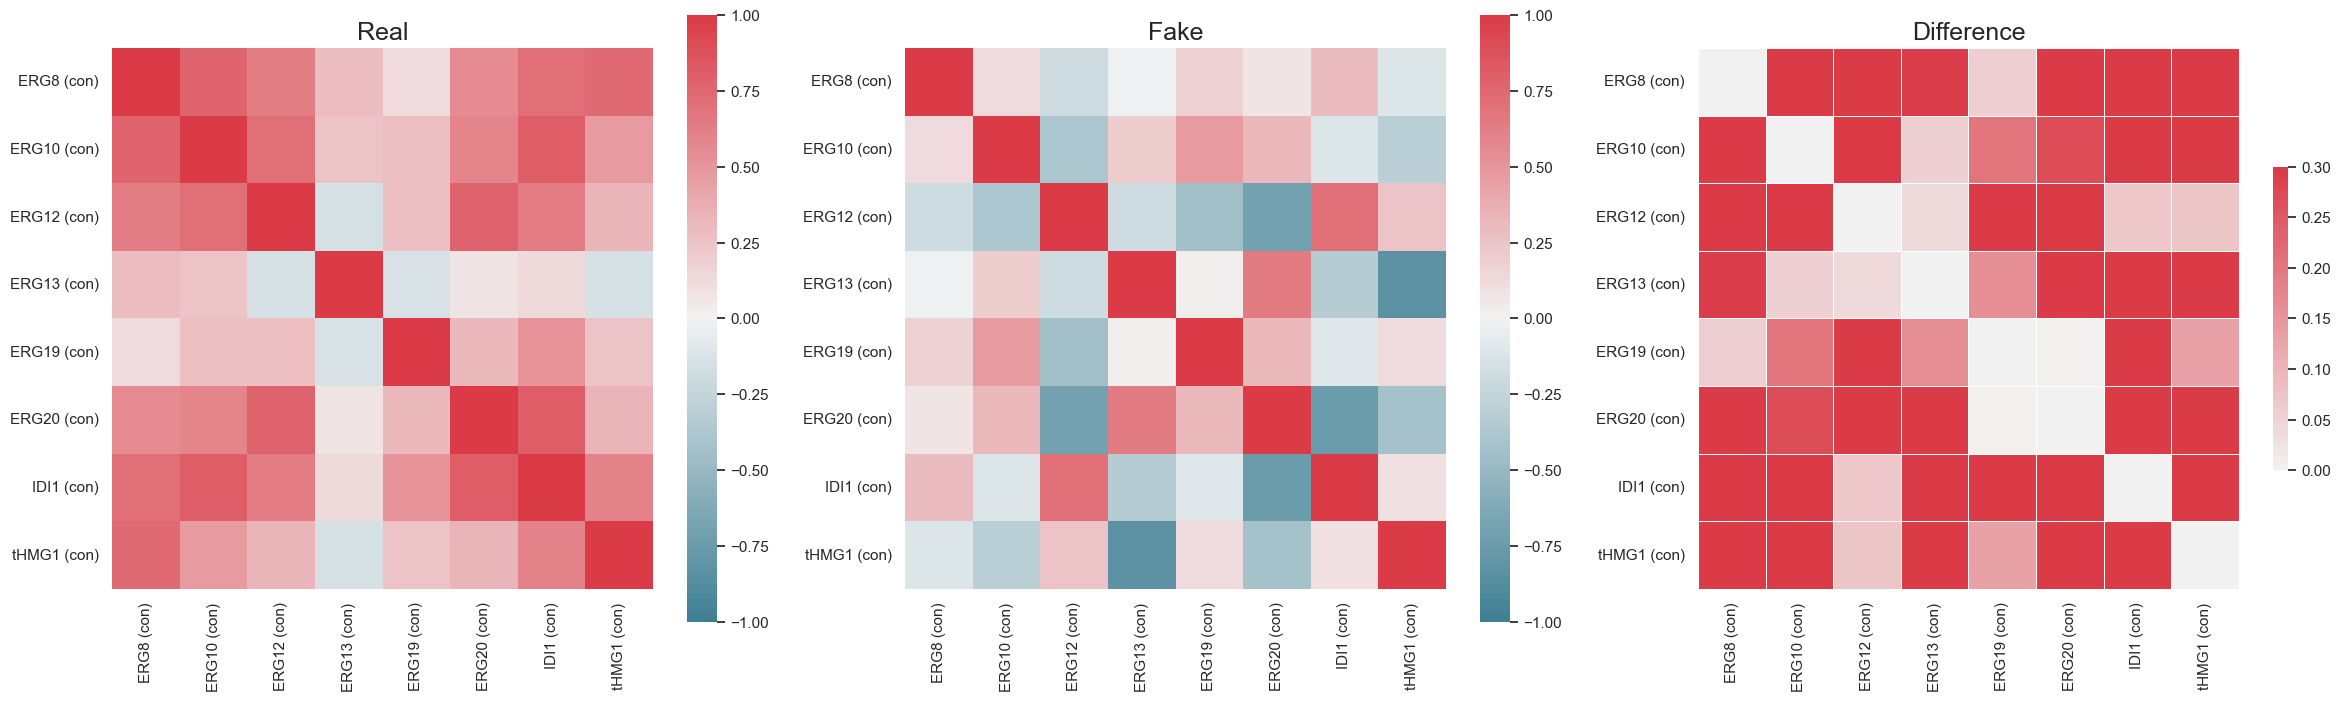

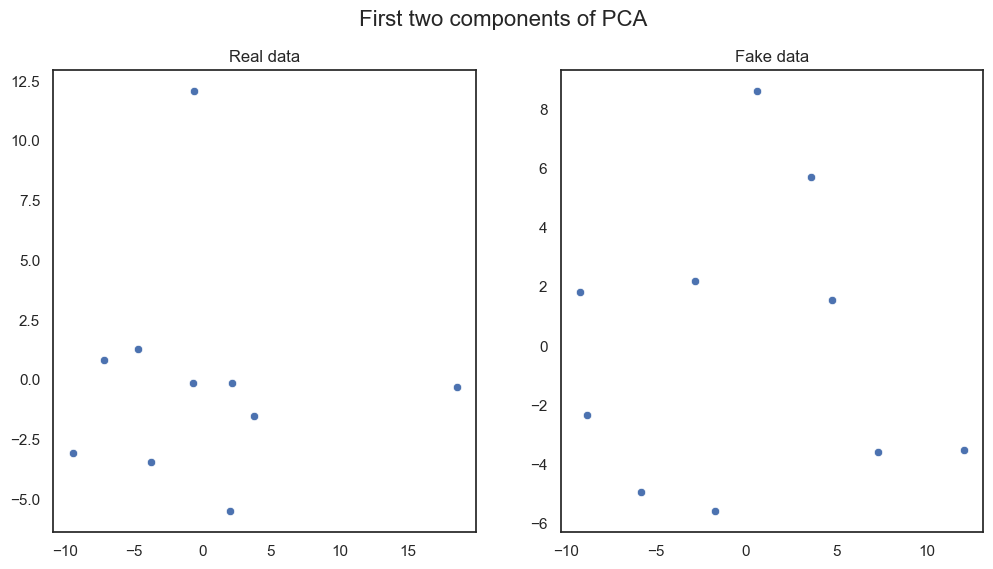

In [62]:
from table_evaluator import TableEvaluator

real_samples = test[INPUT_VARS]
table_evaluator = TableEvaluator(real_samples, sample_df[INPUT_VARS])
table_evaluator.visual_evaluation()

# Counterfactuals (`DiCE`)

In [ ]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = df_A.sort_values("Limonene", ascending=False).index
X_train = X_train.loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = X_train[0:1]

d = dice_ml.Data(
    dataframe=df_A, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn", model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=3,
    desired_range=[70, 80],
    permitted_range=bounds_to_dict(sampling_bounds),
)

cf_df = e1.cf_examples_list[0].final_cfs_df
e1.visualize_as_dataframe(show_only_changes=True)

# PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)
trans_df_A = pca.transform(X_train)
trans_df_B = pca.transform(X_test)
trans_rec = pca.transform(sample_df[INPUT_VARS][:3])

# Plot
plt.scatter(trans_df_A[:, 0], trans_df_A[:, 1], label="DBTL_A")
plt.scatter(trans_df_B[:, 0], trans_df_B[:, 1], label="DBTL_B")
plt.scatter(trans_rec[:, 0], trans_rec[:, 1], label="REC")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.legend()
plt.show()